In [503]:
import pandas as pd
import json
import sklearn

In [504]:
# Load cleaned charging data
charging_data: pd.DataFrame = pd.read_pickle('data/charging_modified.pkl')

# Print head
charging_data.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,weekday,...,month,userRegistered,user_paymentRequired_values,user_requestedDeparture,user_modifiedAt,user_minutesAvailable,user_milesRequested,user_kWhRequested,user_WhPerMile,user_kWhRequestFulfilment
0,5bc90cb9f9af8b0d7fe77cd3,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,2018-04-25 16:44:15+00:00,10.013,2,CA-319,2-39-95-27,NaN,Wednesday,...,4,unregistered,None,None,None,NaN,NaN,NaN,NaN,NaN
1,5bc90cb9f9af8b0d7fe77cd4,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,2018-04-25 14:51:44+00:00,5.257,2,CA-489,2-39-79-380,NaN,Wednesday,...,4,unregistered,None,None,None,NaN,NaN,NaN,NaN,NaN
2,5bc90cb9f9af8b0d7fe77cd5,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00,5.177,2,CA-327,2-39-79-379,NaN,Wednesday,...,4,unregistered,None,None,None,NaN,NaN,NaN,NaN,NaN
3,5bc90cb9f9af8b0d7fe77cd6,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00,10.119,2,CA-490,2-39-79-381,NaN,Wednesday,...,4,unregistered,None,None,None,NaN,NaN,NaN,NaN,NaN
4,5bc90cb9f9af8b0d7fe77cd7,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,2018-04-25 16:18:28+00:00,7.910,2,CA-303,2-39-139-28,NaN,Wednesday,...,4,unregistered,None,None,None,NaN,NaN,NaN,NaN,NaN


## Preparing the data

In [505]:
# Reduce the data to the columns we are interested in
prepared_data = charging_data[['siteID', 'spaceID', 'stationID', 'connectionTime', 'disconnectTime', 'weekday', 'kWhDelivered', 'userRegistered']]
prepared_data.head()

,siteID,spaceID,stationID,connectionTime,disconnectTime,weekday,kWhDelivered,userRegistered
0,2,CA-319,2-39-95-27,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,Wednesday,10.013,unregistered
1,2,CA-489,2-39-79-380,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,Wednesday,5.257,unregistered
2,2,CA-327,2-39-79-379,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,Wednesday,5.177,unregistered
3,2,CA-490,2-39-79-381,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,Wednesday,10.119,unregistered
4,2,CA-303,2-39-139-28,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,Wednesday,7.910,unregistered


In [506]:
# Fix the data types
prepared_data = prepared_data.astype(
    {
        'weekday': 'category',
        'kWhDelivered': 'float64', 
        'userRegistered': 'category'
    }
)
prepared_data.head()

,siteID,spaceID,stationID,connectionTime,disconnectTime,weekday,kWhDelivered,userRegistered
0,2,CA-319,2-39-95-27,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,Wednesday,10.013,unregistered
1,2,CA-489,2-39-79-380,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,Wednesday,5.257,unregistered
2,2,CA-327,2-39-79-379,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,Wednesday,5.177,unregistered
3,2,CA-490,2-39-79-381,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,Wednesday,10.119,unregistered
4,2,CA-303,2-39-139-28,2018-04-25 14:43:50+00:00,2018-04-26 01:17:30+00:00,Wednesday,7.910,unregistered


In [507]:
# Get delta between connection and disconnect time
prepared_data['connectionDurationInSeconds'] = (prepared_data['disconnectTime'] - prepared_data['connectionTime']).dt.total_seconds()

# Remove the date from the time columns and only keep the time
prepared_data['connectionTime'] = pd.to_datetime(prepared_data['connectionTime']).dt.time
prepared_data['connectionTimeInSecondsSinceMidnight'] = prepared_data['connectionTime'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
display(prepared_data.head())

# Convert the time to seconds
df_for_clustering = prepared_data.copy()
df_for_clustering = df_for_clustering.drop(columns=['connectionTime', 'disconnectTime'])

display(df_for_clustering.head())

,siteID,spaceID,stationID,connectionTime,disconnectTime,weekday,kWhDelivered,userRegistered,connectionDurationInSeconds,connectionTimeInSecondsSinceMidnight
0,2,CA-319,2-39-95-27,13:45:10,2018-04-26 00:56:16+00:00,Wednesday,10.013,unregistered,40266.0,49510
1,2,CA-489,2-39-79-380,13:45:50,2018-04-25 23:04:45+00:00,Wednesday,5.257,unregistered,33535.0,49550
2,2,CA-327,2-39-79-379,14:37:06,2018-04-25 23:55:34+00:00,Wednesday,5.177,unregistered,33508.0,52626
3,2,CA-490,2-39-79-381,14:40:34,2018-04-25 23:03:12+00:00,Wednesday,10.119,unregistered,30158.0,52834
4,2,CA-303,2-39-139-28,14:43:50,2018-04-26 01:17:30+00:00,Wednesday,7.910,unregistered,38020.0,53030


,siteID,spaceID,stationID,weekday,kWhDelivered,userRegistered,connectionDurationInSeconds,connectionTimeInSecondsSinceMidnight
0,2,CA-319,2-39-95-27,Wednesday,10.013,unregistered,40266.0,49510
1,2,CA-489,2-39-79-380,Wednesday,5.257,unregistered,33535.0,49550
2,2,CA-327,2-39-79-379,Wednesday,5.177,unregistered,33508.0,52626
3,2,CA-490,2-39-79-381,Wednesday,10.119,unregistered,30158.0,52834
4,2,CA-303,2-39-139-28,Wednesday,7.910,unregistered,38020.0,53030


In [508]:
# Label encode ordinal columns
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df_for_clustering['weekday'] = label_encoder.fit_transform(df_for_clustering['weekday'])

# User registered is not really ordinal, but we will treat it as such and then convert it to boolean
df_for_clustering['userRegistered'] = label_encoder.fit_transform(df_for_clustering['userRegistered'])
df_for_clustering = df_for_clustering.astype({'userRegistered': 'bool'})

display(df_for_clustering.head())

,siteID,spaceID,stationID,weekday,kWhDelivered,userRegistered,connectionDurationInSeconds,connectionTimeInSecondsSinceMidnight
0,2,CA-319,2-39-95-27,6,10.013,True,40266.0,49510
1,2,CA-489,2-39-79-380,6,5.257,True,33535.0,49550
2,2,CA-327,2-39-79-379,6,5.177,True,33508.0,52626
3,2,CA-490,2-39-79-381,6,10.119,True,30158.0,52834
4,2,CA-303,2-39-139-28,6,7.910,True,38020.0,53030


In [509]:
# One hot encode nominal columns
# this increases the dimensionality of the data (labels encoding would imply an ordinal relationship between the values)
df_for_clustering = pd.get_dummies(df_for_clustering, columns=['siteID', 'spaceID', 'stationID'])
display(df_for_clustering.head())

,weekday,kWhDelivered,userRegistered,connectionDurationInSeconds,connectionTimeInSecondsSinceMidnight,siteID_1,siteID_2,spaceID_11900388,spaceID_AG-1F01,spaceID_AG-1F02,...,stationID_2-39-89-25,stationID_2-39-89-439,stationID_2-39-90-26,stationID_2-39-90-440,stationID_2-39-91-437,stationID_2-39-91-441,stationID_2-39-92-436,stationID_2-39-92-442,stationID_2-39-95-27,stationID_2-39-95-444
0,6,10.013,True,40266.0,49510,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,6,5.257,True,33535.0,49550,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,6,5.177,True,33508.0,52626,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6,10.119,True,30158.0,52834,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,6,7.910,True,38020.0,53030,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Normalizing the data

In [510]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data in the range [0, 1]
scaler = MinMaxScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(df_for_clustering), columns=df_for_clustering.columns)
scaled_data.head()

,weekday,kWhDelivered,userRegistered,connectionDurationInSeconds,connectionTimeInSecondsSinceMidnight,siteID_1,siteID_2,spaceID_11900388,spaceID_AG-1F01,spaceID_AG-1F02,...,stationID_2-39-89-25,stationID_2-39-89-439,stationID_2-39-90-26,stationID_2-39-90-440,stationID_2-39-91-437,stationID_2-39-91-441,stationID_2-39-92-436,stationID_2-39-92-442,stationID_2-39-95-27,stationID_2-39-95-444
0,1.0,0.126781,1.0,0.045337,0.573052,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.063391,1.0,0.037712,0.573515,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.062324,1.0,0.037681,0.609118,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.128194,1.0,0.033886,0.611526,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.098751,1.0,0.042793,0.613794,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Clustering

In [511]:
random_state = 42

def kmean(data, n_clusters):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=random_state)
    labels = kmeans.fit_predict(data)
    return labels, kmeans

def pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    return pca_result

def pca_based_kmean(data, n_clusters):
    pca_result = pca(data)
    labels, kmeans = kmean(pca_result, n_clusters)
    return labels, kmeans, pca_result

In [512]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kmeans(data, labels):
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i}')
    plt.legend()
    plt.show() 
    
def perform_kmeans_and_plot(data, n_clusters):
    labels, kmeans, pca_result = pca_based_kmean(data, n_clusters)
    plot_kmeans(pca_result, labels)
    return labels, kmeans, pca_result

## Clustering the whole data

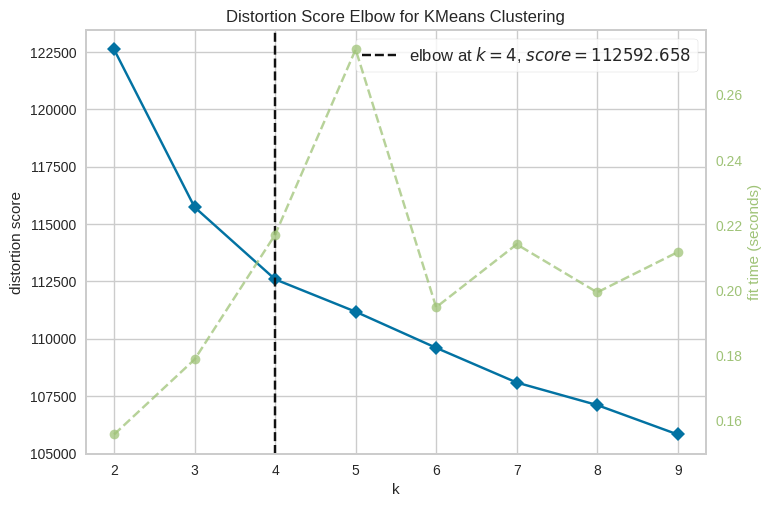

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, n_init='auto', random_state=42),
                 k=(2, 10))

In [513]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

# Find the best number of clusters via elbow method
kelbow_visualizer(KMeans(random_state=random_state, n_init='auto'), scaled_data, k=(2,10))

In [514]:
def cluster_data_and_get_labels(number_of_clusters: int):
    labels, kmeans, pca_result = perform_kmeans_and_plot(scaled_data, number_of_clusters)

    # Group the data by cluster
    scaled_clusters_df = df_for_clustering.copy()
    scaled_clusters_df['cluster'] = labels
    scaled_clusters_df = scaled_clusters_df.groupby('cluster')
    
    # Apply cluster to the original data
    clusters_df_original = prepared_data.copy()
    clusters_df_original['cluster'] = labels
    clusters_df_original = clusters_df_original.groupby('cluster')
    display(clusters_df_original.describe())

    # Raw data unscaled
    return scaled_clusters_df, clusters_df_original

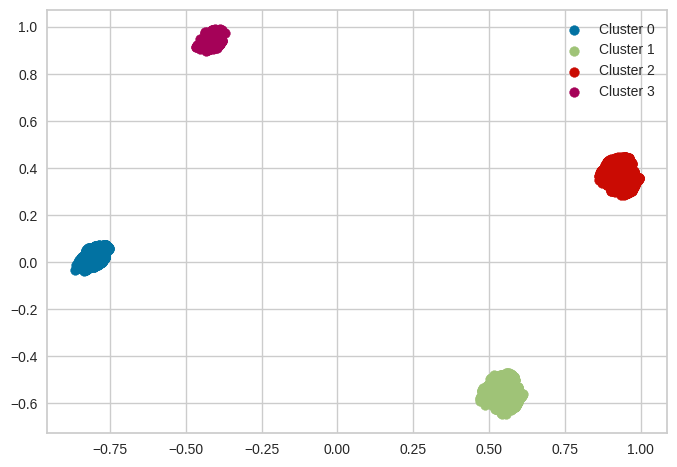

kWhDelivered                                                          \
               count       mean        std    min      25%      50%      75%   
cluster                                                                        
0            23817.0  14.505959  10.922208  0.502  6.91200  11.6030  17.2970   
1            13330.0  10.645785   9.583150  0.510  4.37525   7.7445  13.5480   
2            13869.0   7.272457   5.979187  0.501  2.25200   6.0890  11.6400   
3             1908.0   6.103819   6.540978  0.502  0.84400   3.2810  10.4695   

                connectionDurationInSeconds                ...            \
            max                       count          mean  ...       75%   
cluster                                                    ...             
0        66.971                     23817.0  27127.119327  ...  35230.00   
1        75.528                     13330.0  22894.603676  ...  31670.50   
2        61.550                     13869.0  20025.909150  ...  30476.00   
3        36.898                      1908.0  22813.135220  ...  33339.75   

                  connectionTimeInSecondsSinceMidnight                \
              max                                count          mean   
cluster                                                                
0        194932.0                              23817.0  54877.378595   
1        771559.0                              13330.0  55594.714254   
2        882969.0                              13869.0  49769.978730   
3        211464.0                               1908.0  57378.745807   

                                                                   
                  std   min       25%      50%       75%      max  
cluster                                                            
0        14126.037351  15.0  49898.00  52691.0  57654.00  86397.0  
1        21473.233292   0.0  55508.25  60593.0  67119.75  86387.0  
2        25260.333573   7.0  28167.00  57207.0  66682.00  86388.0  
3        15210.356920  55.0  50539.75  54560.5  67963.50  86381.0  

[4 rows x 24 columns]

In [515]:
df_4_clusters, df_original = cluster_data_and_get_labels(4)

In [516]:
# Visualize the clustered data

Cluster 0


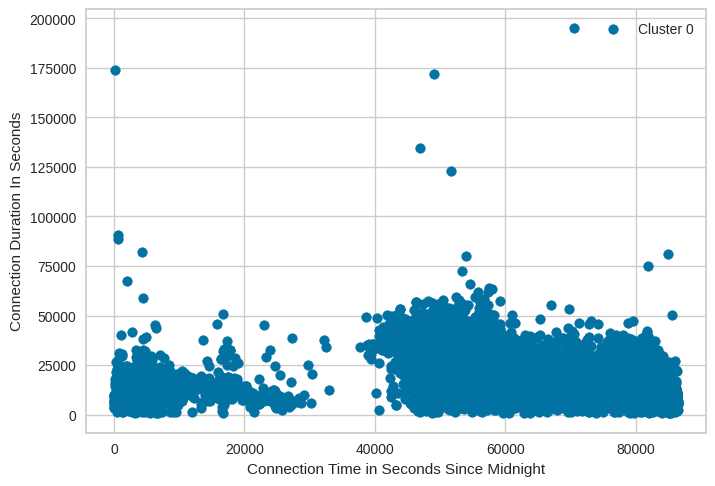

Cluster 1


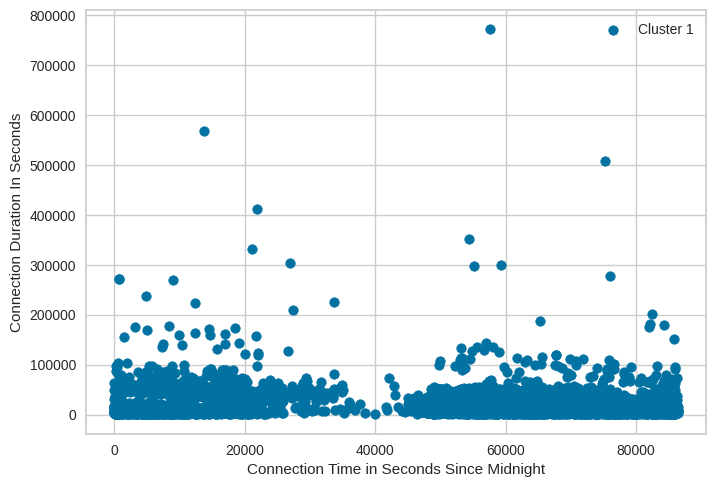

Cluster 2


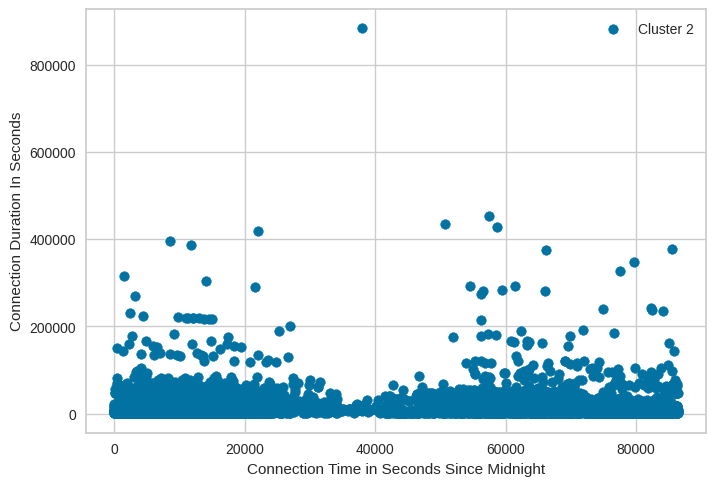

Cluster 3


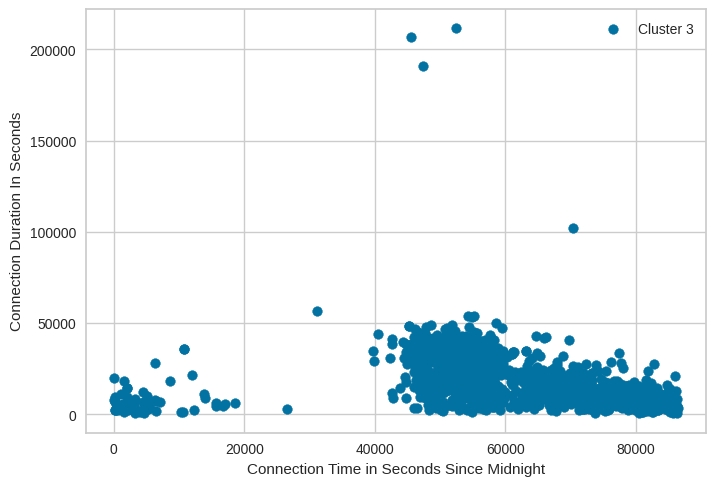

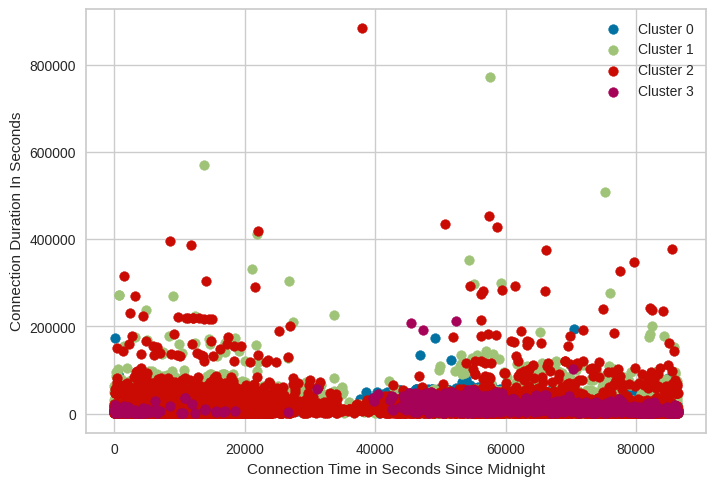

In [517]:
# Plot each cluster individually in an own plot
def plot_each_cluster_individually(clustered_data: pd.DataFrame):
    for name, group in clustered_data:
        print(f'Cluster {name}')
        plt.scatter(group['connectionTimeInSecondsSinceMidnight'], group['connectionDurationInSeconds'], label=f'Cluster {name}')
        plt.xlabel('Connection Time in Seconds Since Midnight')
        plt.ylabel('Connection Duration In Seconds')
        plt.legend()
        plt.show()

def plot_clustered_data(clustered_data: pd.DataFrame):
    for name, group in clustered_data:
        plt.scatter(group['connectionTimeInSecondsSinceMidnight'], group['connectionDurationInSeconds'], label=f'Cluster {name}')
    plt.xlabel('Connection Time in Seconds Since Midnight')
    plt.ylabel('Connection Duration In Seconds')
    plt.legend()
    plt.show()

plot_each_cluster_individually(df_original)    
plot_clustered_data(df_original)